In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import re

In [2]:
#Change the name of the file to match your path
data_minhashing=pd.read_csv("/Users/madalena/Desktop/minhashing_results_subset.csv")
df=data_minhashing
df.shape
df.columns


Index(['signature', 'rating'], dtype='object')

## CLUSTER

DBSCAN


In [ ]:
# == 1. Convert stringified signatures into numeric arrays
#Prepare data for clustering:
#Convert integer to float
df['signature'] = df['signature'].apply(
    lambda s: np.array(re.findall(r'-?\d+', str(s)), dtype=int)
)

#Transform  df['signature'] in lists of length 100 
X = np.array(df['signature'].tolist())
y = df['rating'].values  # true labels

In [4]:
#check X and y shape 
print(X.shape)
print(y.shape)

(500000, 100)
(500000,)


In [8]:
#If you want to run it with a subsample
# pick e.g. 10,000 points for DBSCAN (adjust if needed)
subset_size = 10000
indices_sub = np.random.choice(len(X), size=subset_size, replace=False)

X_sub = X[indices_sub]
print("Feature matrix shape:", X_sub.shape)

Feature matrix shape: (10000, 100)


In [10]:
#Use UMAP before
#If you want to run it with a subsample, change "X" for "X_sub"
import umap

umap_model = umap.UMAP(
    n_neighbors=30,      # controls local vs global structure
    min_dist=0.0,        # tighter clusters
    n_components=15,      # 2–10 recommended
    metric='euclidean',
    random_state=42
)
X_umap = umap_model.fit_transform(X_sub)

/Users/madalena/miniforge3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
# To choose Eps, use the elbow method

# Use k=2 because the first neighbor is the point itself
nbrs = NearestNeighbors(n_neighbors=2).fit(X_umap)
distances, indices = nbrs.kneighbors(X_umap)

# Take distance to the nearest neighbor (excluding itself)
nearest_dist = np.sort(distances[:,1])  # skip distance to self

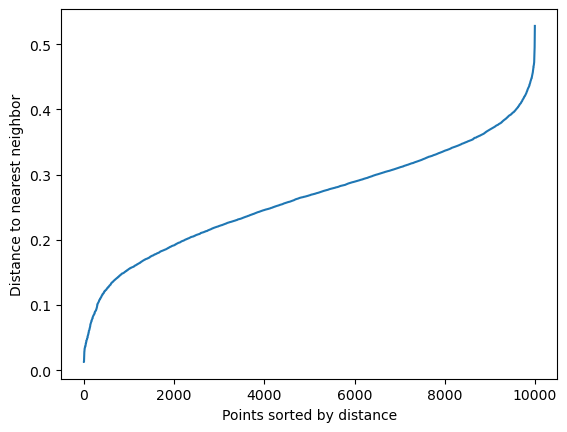

In [12]:
plt.plot(nearest_dist)
plt.ylabel("Distance to nearest neighbor")
plt.xlabel("Points sorted by distance")
plt.show()

In [13]:
eps = np.percentile(nearest_dist, 95)
print(eps)

0.3943019689528646


In [15]:
#Check, varying percentile, p, if it is possible to obtain an outcome different than one big bluster and noise
for p in [60, 70, 80, 85, 90, 95]:
    eps_test = np.percentile(nearest_dist, p)
    db_test = DBSCAN(eps=eps_test, min_samples=20).fit_predict(X_umap)
    unique, counts = np.unique(db_test, return_counts=True)
    print(f"Percentile {p}, eps={eps_test:.4f}", dict(zip(unique, counts)))

Percentile 60, eps=0.2892 {np.int64(-1): np.int64(7688), np.int64(0): np.int64(1076), np.int64(1): np.int64(1073), np.int64(2): np.int64(52), np.int64(3): np.int64(39), np.int64(4): np.int64(33), np.int64(5): np.int64(19), np.int64(6): np.int64(20)}
Percentile 70, eps=0.3111 {np.int64(-1): np.int64(6986), np.int64(0): np.int64(1371), np.int64(1): np.int64(30), np.int64(2): np.int64(1296), np.int64(3): np.int64(52), np.int64(4): np.int64(58), np.int64(5): np.int64(13), np.int64(6): np.int64(92), np.int64(7): np.int64(26), np.int64(8): np.int64(36), np.int64(9): np.int64(20), np.int64(10): np.int64(20)}
Percentile 80, eps=0.3367 {np.int64(-1): np.int64(6115), np.int64(0): np.int64(1687), np.int64(1): np.int64(43), np.int64(2): np.int64(1754), np.int64(3): np.int64(55), np.int64(4): np.int64(96), np.int64(5): np.int64(15), np.int64(6): np.int64(28), np.int64(7): np.int64(44), np.int64(8): np.int64(24), np.int64(9): np.int64(41), np.int64(10): np.int64(20), np.int64(11): np.int64(58), np.i

In [17]:
eps = 0.39 #adjust after checking the curve in the plot
min_samples = 15

# 3. Run DBSCAN 
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
clusters = dbscan.fit_predict(X_umap)
print("DBSCAN cluster labels distribution:")

#Print Cluster distribution
unique, counts = np.unique(clusters, return_counts=True)
print("Clusters distribution:", dict(zip(unique, counts)))

DBSCAN cluster labels distribution:
Clusters distribution: {np.int64(-1): np.int64(2852), np.int64(0): np.int64(6652), np.int64(1): np.int64(119), np.int64(2): np.int64(168), np.int64(3): np.int64(50), np.int64(4): np.int64(43), np.int64(5): np.int64(28), np.int64(6): np.int64(30), np.int64(7): np.int64(12), np.int64(8): np.int64(27), np.int64(9): np.int64(19)}


In [18]:
clusters=clusters+1 

In [23]:
#EVALUATION using DAVIES-BOULDIN INDEX
def DB(X, clusters):
    db = davies_bouldin_score(X_umap, clusters)
    return db


#Evaluate HDBSCAN
db_DBscan = DB(X_umap, clusters)
print(f"Davies-Bouldin Index (DB) for HDBSCAN: {db_DBscan:.4f}")

Davies-Bouldin Index (DB) for HDBSCAN: 6.5522


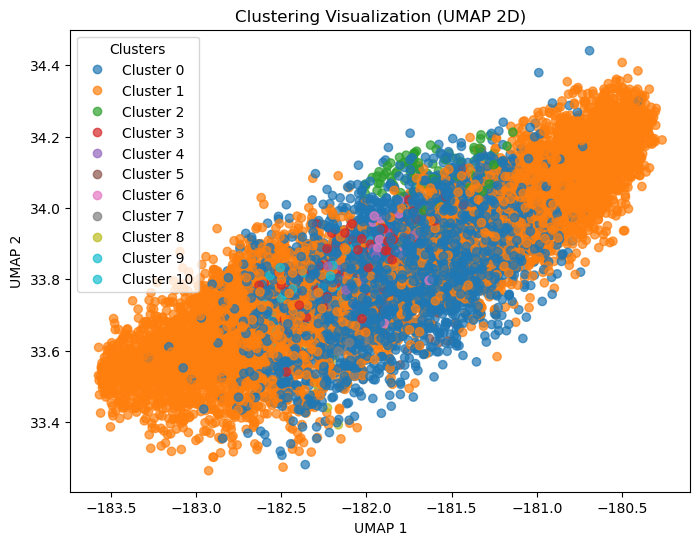

In [24]:
#VISUALIZATION of CLUSTERS
# Reduce to 2D using UMAP
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1],
                      c=clusters, cmap='tab10', alpha=0.7)

# Legend for cluster IDs
handles, labels = scatter.legend_elements()
plt.legend(handles, [f"Cluster {i}" for i in np.unique(clusters)], 
           title="Clusters")

plt.title("Clustering Visualization (UMAP 2D)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [ ]:
#ANALYSIS OF CLUSTERS WITH RESPECT TO RATINGS
# Create dataframe containing ratings and cluster assignments
df_results = pd.DataFrame({
    'rating': y,
    'cluster': clusters
})

#Table showing distribution of ratings per cluster
cluster_summary = pd.crosstab(df_results['cluster'], df_results['rating'])
print(cluster_summary)

#print heatmap 
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Distribution of Ratings per Cluster")
plt.xlabel("Rating")
plt.ylabel("Cluster")
plt.show()

#Normalize the values to take into account the size of each group of rating 
for i in range(1,6):
    cluster_summary[i] = cluster_summary[i] / cluster_summary[i].sum()
print(cluster_summary)

#print heatmap 
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Normalized Distribution of Ratings per Cluster")
plt.xlabel("Rating")
plt.ylabel("Cluster")
plt.show()

ValueError: All arrays must be of the same length